In [1]:
from functions.peakutils import *
from functions.files import *
from functions.modelfitting import *
from functions.otherfunctions import *
from functions.peakselection import *
from functions.plotting import *

In [2]:
plt.rcParams['figure.figsize'] = [16, 4]

In [3]:
# Load already processed peaklists to save time
peaklists = loadPeaklists("peaklists/1/")
peaklists2 = loadPeaklists("peaklists/2/")
peaklists3 = loadPeaklists("peaklists/3/")

10/60 files loaded.
20/60 files loaded.
30/60 files loaded.
40/60 files loaded.
50/60 files loaded.
60/60 files loaded.
10/29 files loaded.
20/29 files loaded.
10/100 files loaded.
20/100 files loaded.
30/100 files loaded.
40/100 files loaded.
50/100 files loaded.
60/100 files loaded.
70/100 files loaded.
80/100 files loaded.
90/100 files loaded.
100/100 files loaded.


In [4]:
# example

import numpy as np
import pandas as pd

files = ["Example_Inputs/test/spectrum_2020-00-17_17_11_07.csv",
         "Example_Inputs/test/spectrum_2020-00-17_17_11_18.csv",
         "Example_Inputs/test/spectrum_2020-00-17_21_11_31.csv",
        "Example_Inputs/test/spectrum_2020-00-17_17_11_40.csv"]

data1 = readFile(files[0])
data2 = readFile(files[1])
data3 = readFile(files[2])
data4 = readFile(files[3])

In [5]:
import pandas as pd

import numpy as np

# Takes a long time if there are many files
#peaklists = getPeaklists("data/testdata")

peaklist = identifyPeaks(data1, pd.read_csv("KOionfolder/Allions1ex.csv"), 5e-4)
#peaklist2 = identifyPeaks(data2, pd.read_csv("peaklist.csv"), 5e-4)
#peaklist3 = identifyPeaks(data3, pd.read_csv("peaklist.csv"), 5e-4)
#peaklist4 = identifyPeaks(data4, pd.read_csv("peaklist.csv"), 5e-4)

print(peaklist)

C:\Users\Jaakko\anaconda3\lib\site-packages\scipy\optimize\optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))


         formula          mz    observed             a     sigma   peak
1           O3N-   61.988366   61.988374  2.194915e+06  0.000094    5.0
2       O3N[15]-   62.985401   62.985426  7.337760e+03  0.000096   10.0
3      O2O[17]N-   62.992584   62.992604  2.351821e+03  0.000096   11.0
4      O2O[18]N-   63.992613   63.992624  1.386558e+04  0.000097   12.0
9         C2HO4-   88.988032   88.988122  2.313051e+03  0.000135   15.0
..           ...         ...         ...           ...       ...    ...
262  C14H16O5NF-  297.101799  297.101841  9.729300e+02  0.000451   96.0
266   C11H16O9N-  306.083055  306.082588  2.298653e+02  0.000464   97.0
269  C10H14O10N-  308.062319  308.062115  8.128451e+02  0.000467   98.0
274  C10H16O10N-  310.077969  310.077611  6.271590e+02  0.000470   99.0
282  C10H14O11N-  324.057234  324.057232  4.911236e+02  0.000491  100.0

[78 rows x 6 columns]


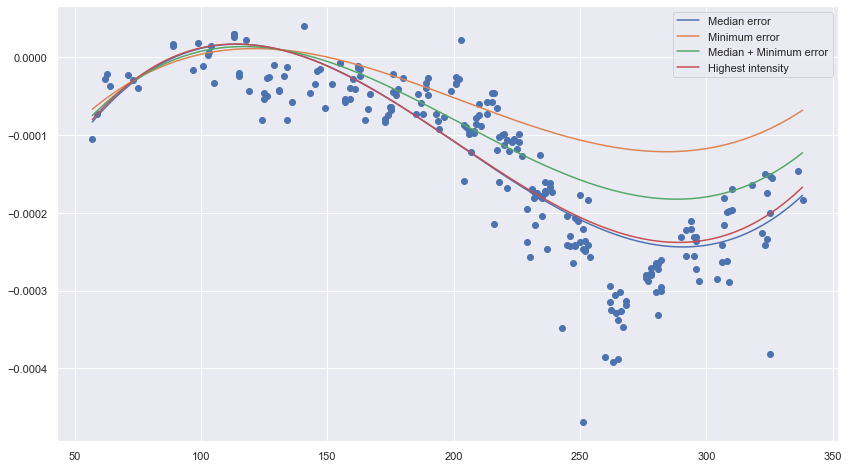

Median error:
8.92% of the prefit MSE

Minimum error:
34.46% of the prefit MSE

Median + Minimum error:
16.44% of the prefit MSE

Highest intensity:
11.45% of the prefit MSE


array([0.08915701, 0.34459279, 0.16443173, 0.11450795])

In [13]:
plt.rcParams['figure.figsize'] = [14, 8]
fitPolynomialAll(peaklists2[13], 4, 2, 12, 0.5, True, True)[2]

In [7]:
# These will take a long time to run
errors2HI = calculateErrors(peaklists2, selectPeaksHighestIntensity, 20, 30)

In [151]:
errors2Med = calculateErrors(peaklists2, selectPeaksMedianError, 20, 30)
errors2Mean = calculateErrors(peaklists2, selectPeaksMeanError, 20, 30)
errors2Min = calculateErrors(peaklists2, selectPeaksMinimumError, 20, 30)

In [152]:
errors1HI = calculateErrors(peaklists, selectPeaksHighestIntensity, 20, 30)
errors1Med = calculateErrors(peaklists, selectPeaksMedianError, 20, 30)
errors1Mean = calculateErrors(peaklists, selectPeaksMeanError, 20, 30)
errors1Min = calculateErrors(peaklists, selectPeaksMinimumError, 20, 30)

C:\Users\Jaakko\Documents\GitHub\DataScienceProject1-Orbitrap\functions\plotting.py:132: RuntimeWarning: divide by zero encountered in log
  avg[i,ii]=np.log(np.mean(errors[degree,:,i,ii]))


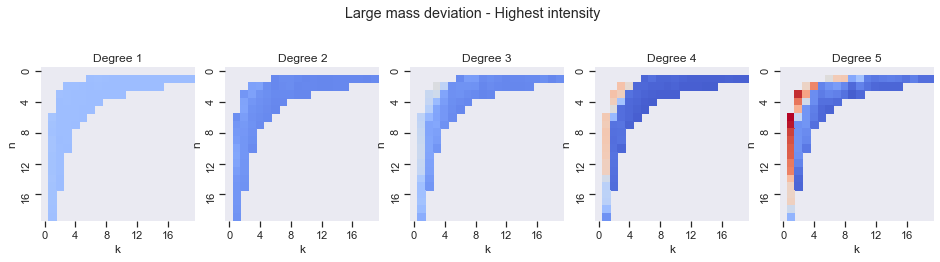

In [8]:
plotPeaklists3(errors2HI, "Large mass deviation - Highest intensity")

In [21]:
plt.rcParams['figure.figsize'] = [12, 12]

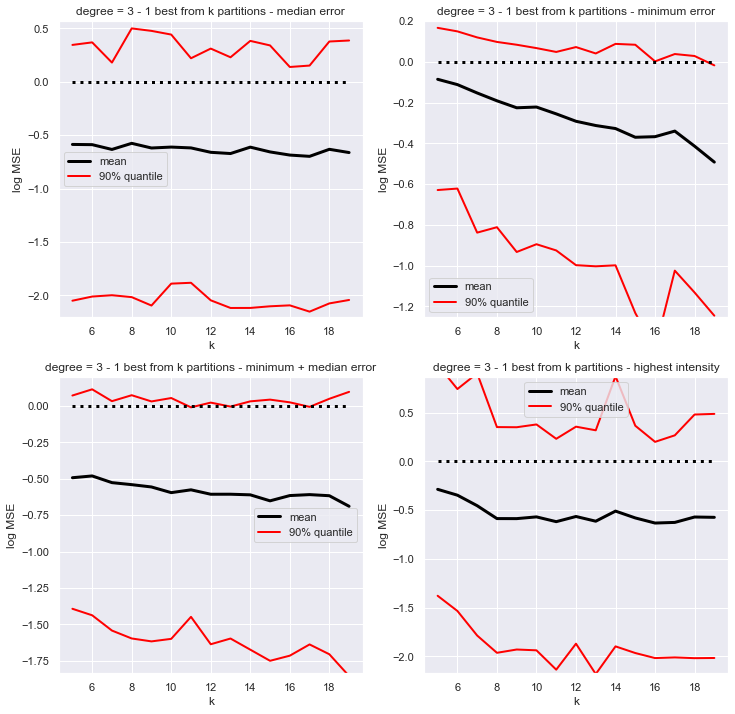

In [22]:
plotPeaklists(peaklists3, 3, False, 1, 5, 15)

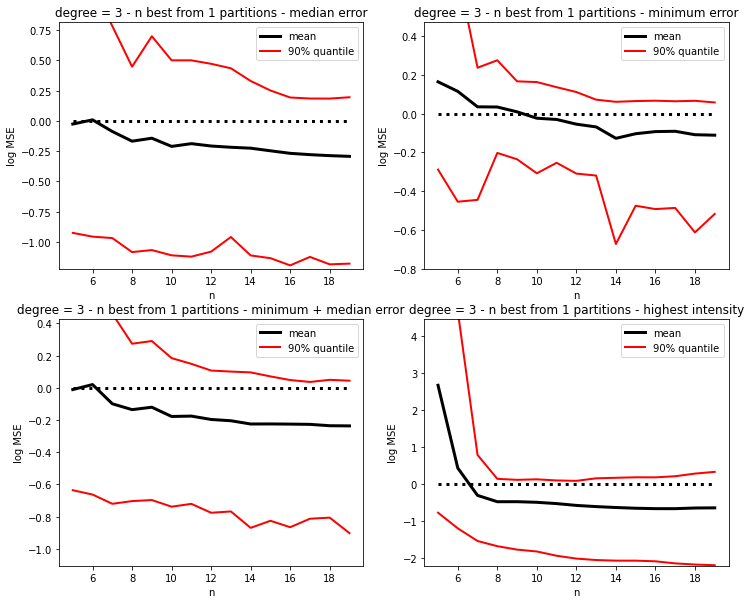

In [68]:
plotPeaklists(peaklists3, 3, True, 5, 1, 15)

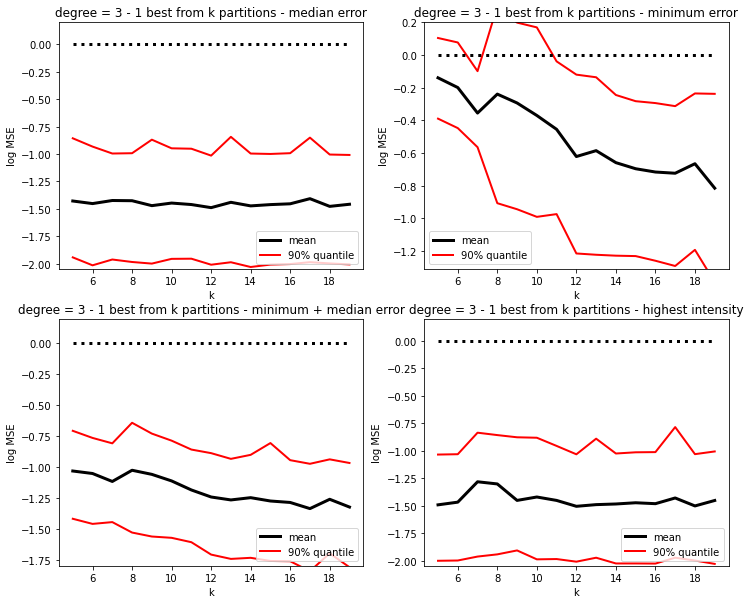

In [69]:
plotPeaklists(peaklists2, 3, False, 1, 5, 15)

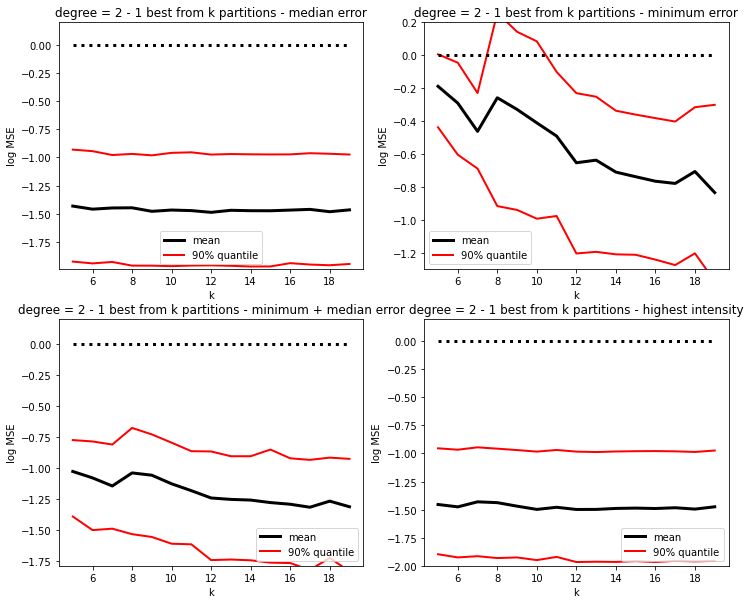

In [70]:
plotPeaklists(peaklists2, 2, False, 1, 5, 15)

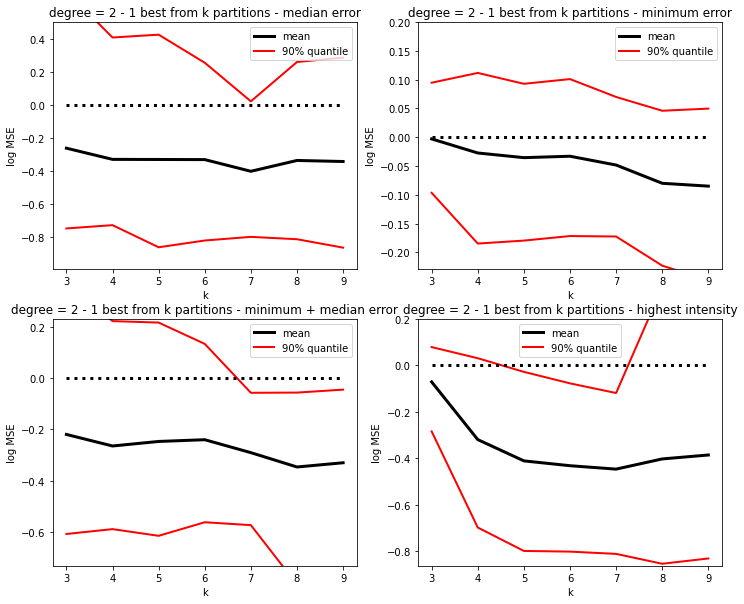

In [71]:
plotPeaklists(peaklists, 2, False, 1, 3, 7)

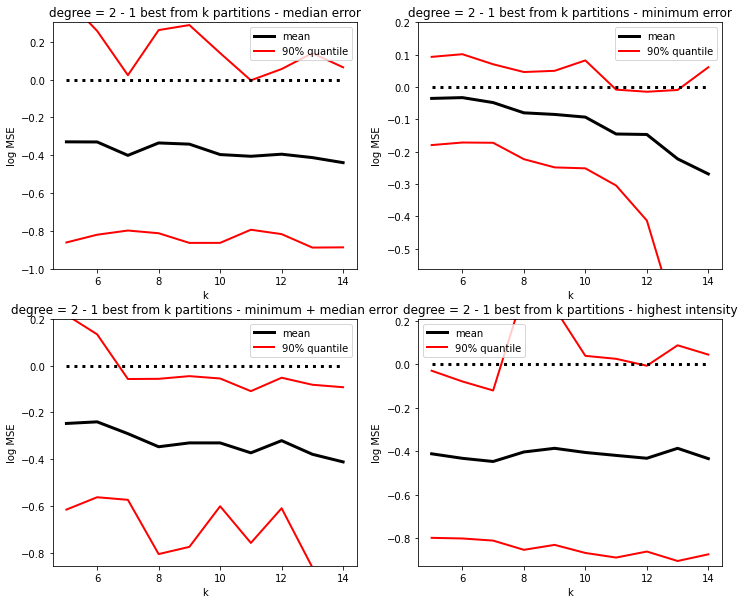

In [72]:
plotPeaklists(peaklists, 2, False, 1, 5, 10)

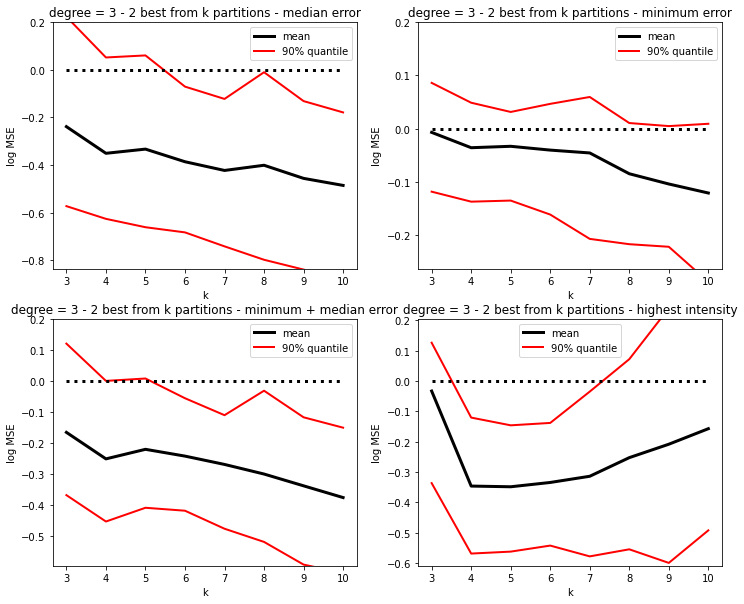

In [116]:
plotPeaklists(peaklists, 3, False, 2, 3, 8)

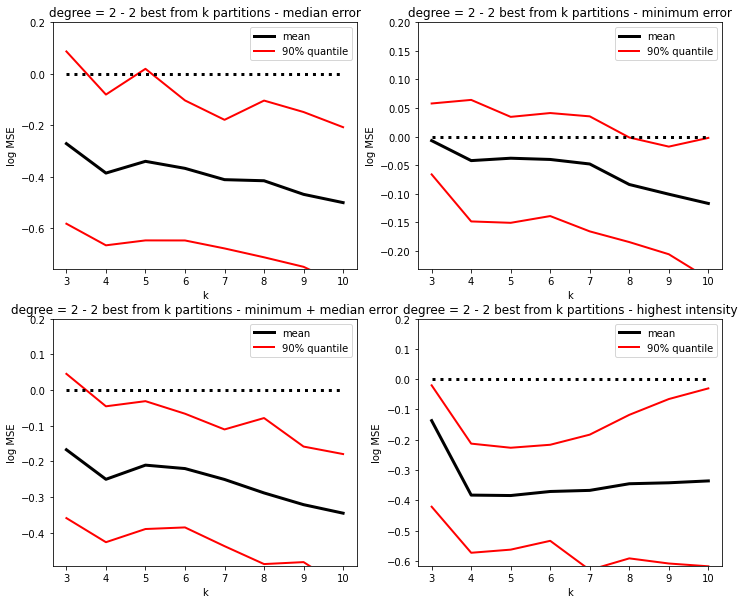

In [117]:
plotPeaklists(peaklists, 2, False, 2, 3, 8)

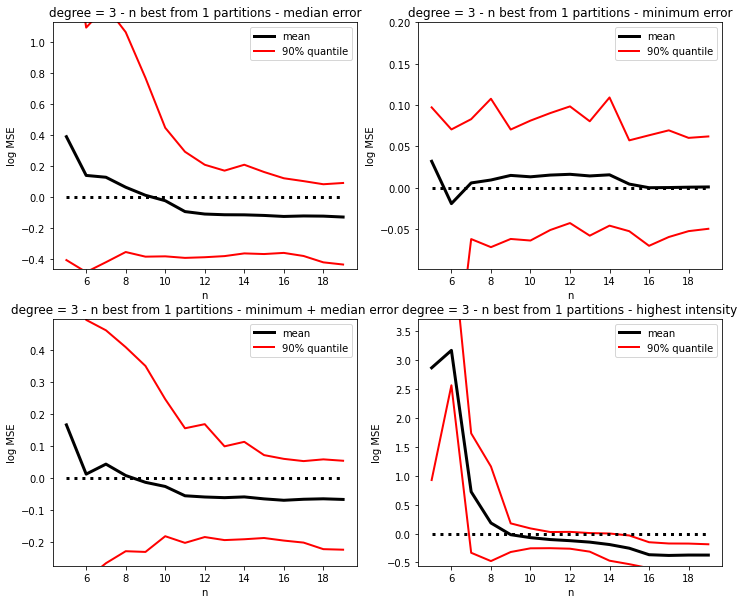

In [118]:
plotPeaklists(peaklists, 3, True, 5, 1, 15)

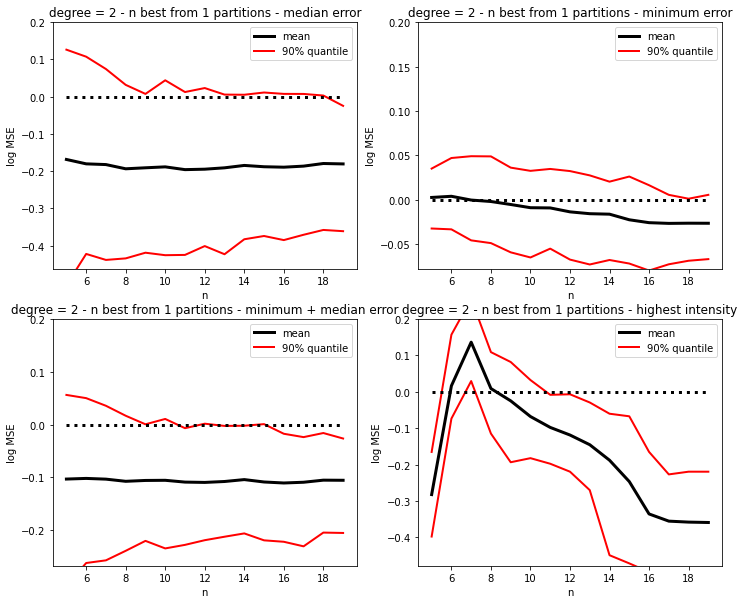

In [119]:
plotPeaklists(peaklists, 2, True, 5, 1, 15)

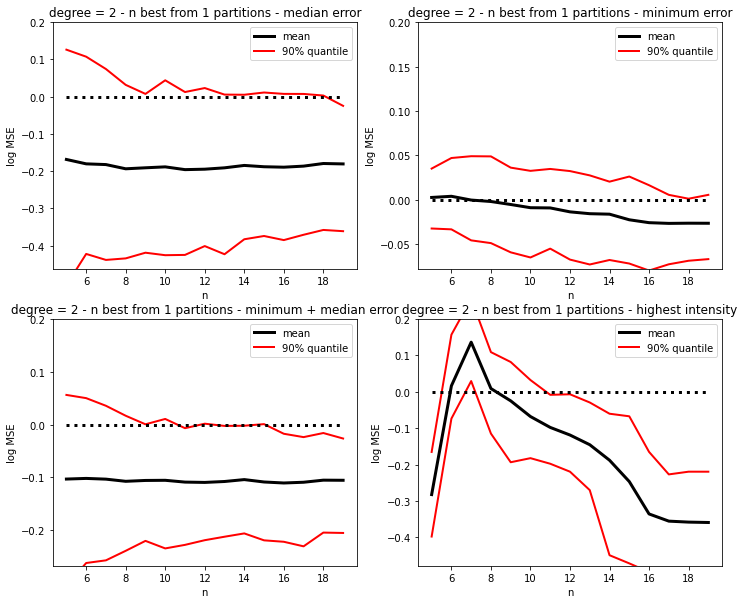

In [120]:
plotPeaklists(peaklists, 2, True, 5, 1, 15)

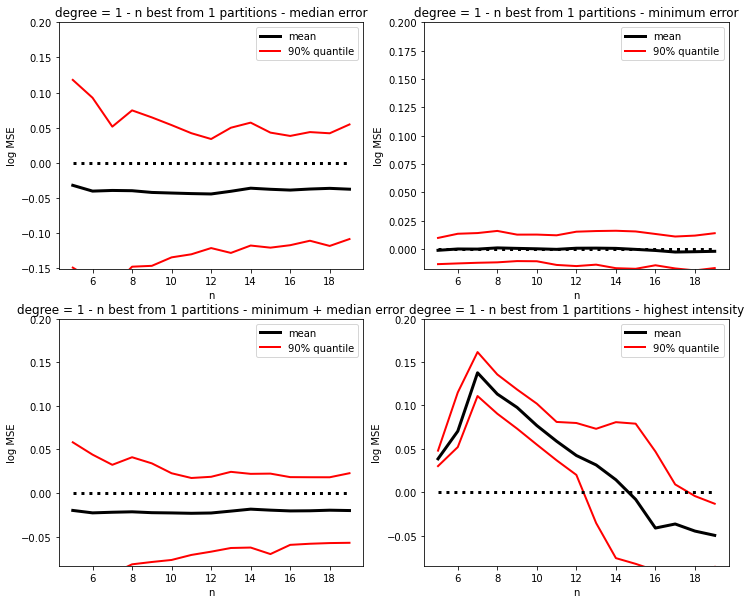

In [121]:
plotPeaklists(peaklists, 1, True, 5, 1, 15)

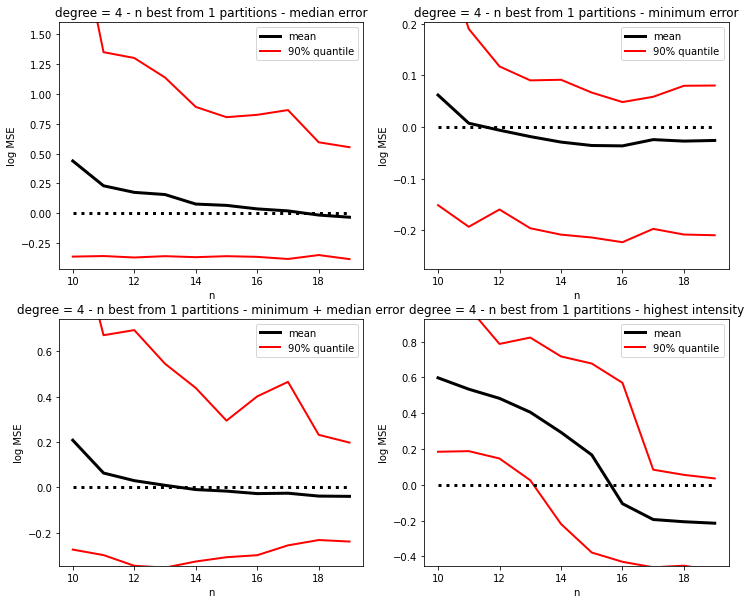

In [130]:
plotPeaklists(peaklists, 4, True, 10, 1, 10)

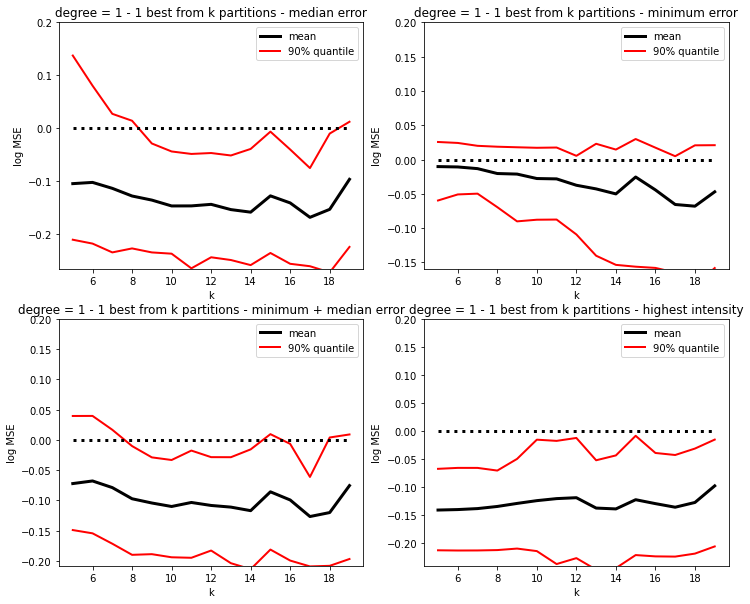

In [123]:
plotPeaklists(peaklists, 1, False, 1, 5, 15)

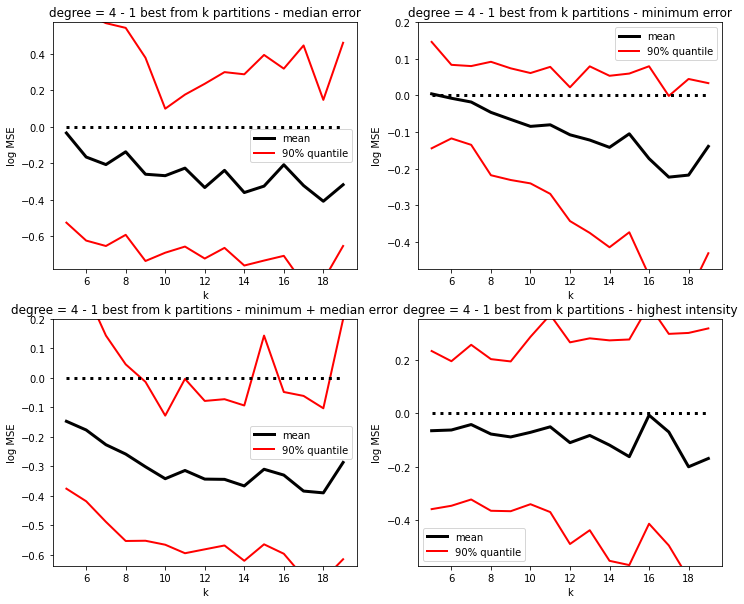

In [124]:
plotPeaklists(peaklists, 4, False, 1, 5, 15)

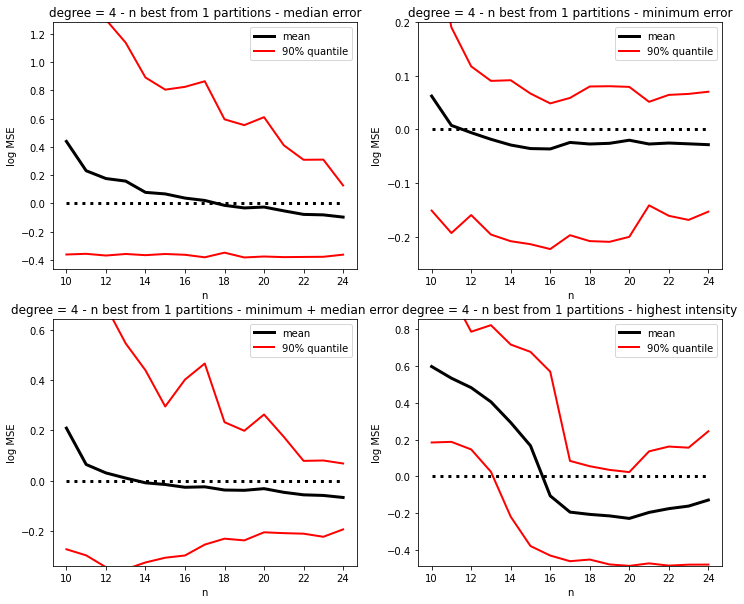

In [125]:
plotPeaklists(peaklists, 4, True, 10, 1, 15)

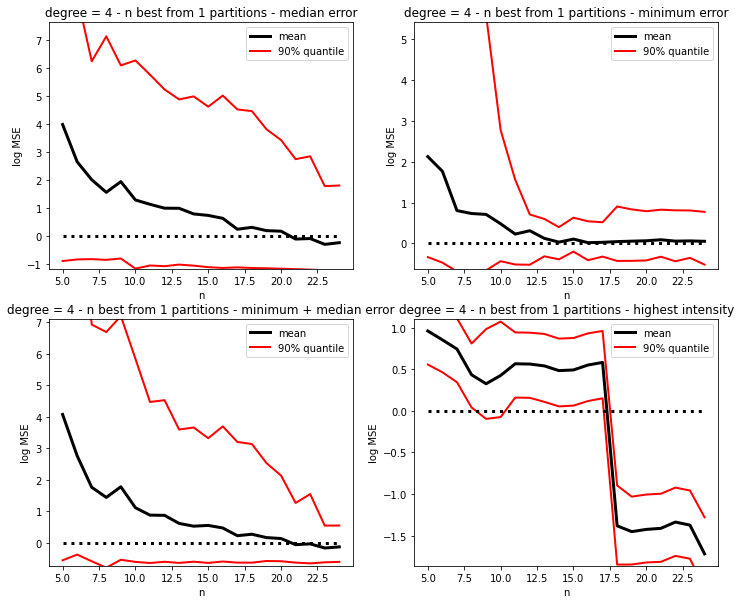

In [126]:
plotPeaklists(peaklists2, 4, True, 5, 1, 20)

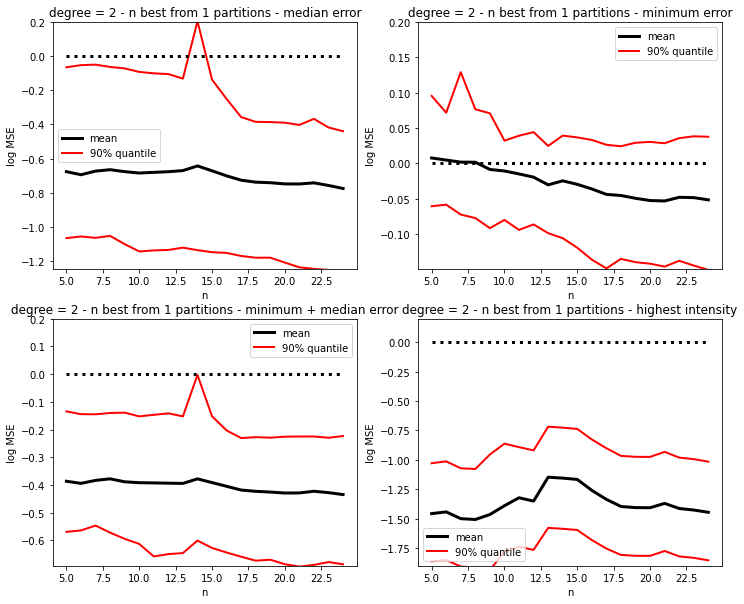

In [127]:
plotPeaklists(peaklists2, 2, True, 5, 1, 20)

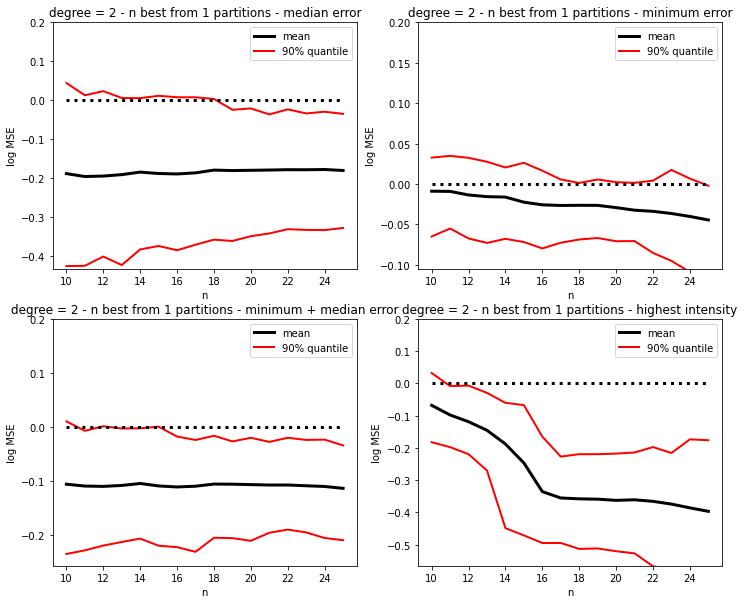

In [133]:
plotPeaklists(peaklists, 2, True, 10, 1, 16)

In [23]:
peaklists = [peaklist, peaklists2[0], peaklists3[0]]
combineObservations(peaklists)

,mz,observed,observed_1,observed_2
formula,,,,
O3N-,61.988366,61.988374,61.988338,61.988397
O3N[15]-,62.985401,62.985426,62.985380,62.985445
O2O[17]N-,62.992584,62.992604,62.992561,62.992632
O2O[18]N-,63.992613,63.992624,63.992575,63.992645
C2HO4-,88.988032,88.988122,88.988044,88.988157
...,...,...,...,...
C14H16O5NF-,297.101799,297.101841,297.101804,297.101840
C11H16O9N-,306.083055,306.082588,306.082841,306.082949
C10H14O10N-,308.062319,308.062115,308.062108,308.062214


In [24]:
print(getLogIntensity(peaklist.iloc[0,3], peaklist.iloc[0,4]))
print(getIntensity(peaklist.iloc[0,3], peaklist.iloc[0,4]))

24.792654767490447
58521191151.14881


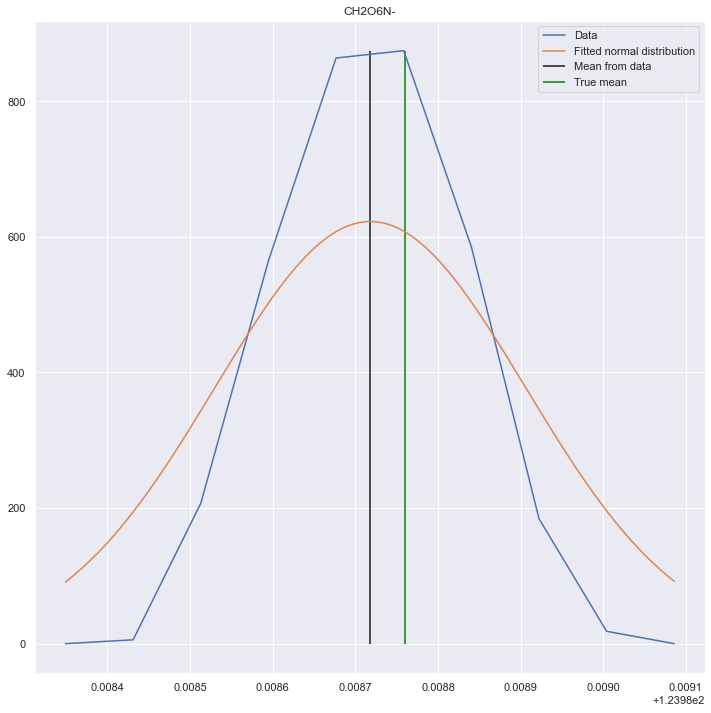

In [25]:
# Plot a peak
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

i = 8
plotPeak(i, peaklist, data1)